# Matching utilities

- expected_kth_values(n, trials=10000, seed=None) -> list[float]:
	Returns E[total weight] of the k-th max matching for k=1..n in K(n,n) with Uniform[0,1] edges.
- plot_kth_distribution(n, k, trials=10000, bins=50, seed=None):
	Plots histogram of total weight for the k-th max matching.

In [23]:
import math
import random

# Fast paths: try NumPy for RNG and vectorized ops
try:
	import numpy as np
	_HAVE_NUMPY = True
except Exception:
	np = None
	_HAVE_NUMPY = False

_FAST_HUNGARIAN = None
try:
	from scipy.optimize import linear_sum_assignment as _SCIPY_LSA
except Exception:
	_SCIPY_LSA = None

# Announce backend once
_BACKEND_ANNOUNCED = False
def _announce_backend(msg: str):
	global _BACKEND_ANNOUNCED
	if not _BACKEND_ANNOUNCED:
		try:
			print(msg)
		except Exception:
			pass
		_BACKEND_ANNOUNCED = True

def _solve_cost_with_scipy(a):
	# SciPy linear_sum_assignment minimizes total cost over the given matrix
	arr = a if (_HAVE_NUMPY and isinstance(a, np.ndarray)) else np.array(a, dtype=float, copy=False)
	r, c = _SCIPY_LSA(arr)
	cost = float(arr[r, c].sum())
	ans = [-1] * arr.shape[0]
	for i, j in zip(r.tolist(), c.tolist()):
		ans[int(i)] = int(j)
	return cost, ans

LARGE = 1e18

# Label helper for plot titles
def _dist_label(dist: str, rate: float) -> str:
	if dist == "uniform":
		return "U[0,1]"
	if dist == "exponential":
		return f"Exp(\u03BB={rate:g})"
	return dist

def hungarian(a):
	if not a:
		return 0.0, []
	# Prefer fast backends if available
	if _FAST_HUNGARIAN is not None:
		_announce_backend("Using fast Hungarian solver from match.py")
		return _FAST_HUNGARIAN(a)
	if _SCIPY_LSA is not None:
		_announce_backend("Using SciPy linear_sum_assignment for Hungarian solver")
		return _solve_cost_with_scipy(a)
	# Built-in fallback
	_announce_backend("Using built-in Hungarian solver")
	# ...existing code...
	n = len(a)
	m = len(a[0]) if n else 0
	u = [0.0] * (n + 1)
	v = [0.0] * (m + 1)
	p = [0] * (m + 1)
	for i in range(1, n + 1):
		p[0] = i
		j0 = 0
		minv = [float('inf')] * (m + 1)
		used = [False] * (m + 1)
		way = [-1] * (m + 1)
		while True:
			used[j0] = True
			i0 = p[j0]
			delta = float('inf')
			j1 = 0
			for j in range(1, m + 1):
				if not used[j]:
					cur = a[i0 - 1][j - 1] - u[i0] - v[j]
					if cur < minv[j]:
						minv[j] = cur
						way[j] = j0
					if minv[j] < delta:
						delta = minv[j]
						j1 = j
			for j in range(m + 1):
				if used[j]:
					u[p[j]] += delta
					v[j] -= delta
				else:
					minv[j] -= delta
			j0 = j1
			if p[j0] == 0:
				break
		while True:
			j1 = way[j0]
			p[j0] = p[j1]
			j0 = j1
			if j0 == 0:
				break
	ans = [-1] * n
	for j in range(1, m + 1):
		if p[j]:
			ans[p[j] - 1] = j - 1
	return -v[0], ans

# Reusable Hungarian solver to avoid repeated allocations
class HungarianSolver:
	def __init__(self, n: int, m: int | None = None):
		if m is None:
			m = n
		self.n = n
		self.m = m
		self.u = [0.0] * (n + 1)
		self.v = [0.0] * (m + 1)
		self.p = [0] * (m + 1)
		self.minv = [0.0] * (m + 1)
		self.used = [False] * (m + 1)
		self.way = [-1] * (m + 1)

	def solve(self, a):
		# If fast backends exist, delegate
		if _FAST_HUNGARIAN is not None:
			_announce_backend("Using fast Hungarian solver from match.py")
			return _FAST_HUNGARIAN(a)
		if _SCIPY_LSA is not None:
			_announce_backend("Using SciPy linear_sum_assignment for Hungarian solver")
			return _solve_cost_with_scipy(a)
		# Built-in fallback
		_announce_backend("Using built-in Hungarian solver")
		# ...existing code...
		n, m = self.n, self.m
		u, v, p, minv, used, way = self.u, self.v, self.p, self.minv, self.used, self.way
		for i in range(n + 1):
			u[i] = 0.0
		for j in range(m + 1):
			v[j] = 0.0
			p[j] = 0
		# main loop
		for i in range(1, n + 1):
			p[0] = i
			j0 = 0
			for j in range(m + 1):
				minv[j] = float('inf')
				used[j] = False
				way[j] = -1
			while True:
				used[j0] = True
				i0 = p[j0]
				delta = float('inf')
				j1 = 0
				ai0 = a[i0 - 1]
				for j in range(1, m + 1):
					if not used[j]:
						cur = ai0[j - 1] - u[i0] - v[j]
						if cur < minv[j]:
							minv[j] = cur
							way[j] = j0
						if minv[j] < delta:
							delta = minv[j]
							j1 = j
				for j in range(m + 1):
					if used[j]:
						u[p[j]] += delta
						v[j] -= delta
					else:
						minv[j] -= delta
				j0 = j1
				if p[j0] == 0:
					break
			while True:
				j1 = way[j0]
				p[j0] = p[j1]
				j0 = j1
				if j0 == 0:
					break
		ans = [-1] * n
		for j in range(1, m + 1):
			if p[j]:
				ans[p[j] - 1] = j - 1
		return -v[0], ans

def _make_rng(seed):
	if _HAVE_NUMPY:
		return np.random.default_rng(seed)
	return random.Random(seed) if seed is not None else random

def _random_matrix(n: int, rng, dist: str = "uniform", rate: float = 1.0):
	if dist == "exponential" and rate <= 0:
		raise ValueError("rate must be > 0 for exponential distribution")
	if _HAVE_NUMPY and hasattr(rng, "random"):
		if dist == "uniform":
			return -rng.random((n, n))
		elif dist == "exponential":
			# numpy exponential uses scale=1/lambda
			return -rng.exponential(scale=1.0 / rate, size=(n, n))
		else:
			raise ValueError(f"unknown dist: {dist}")
	# Fallback: pure Python
	if dist == "uniform":
		return [[-rng.random() for _ in range(n)] for _ in range(n)]
	elif dist == "exponential":
		# random.Random and random module both have expovariate(lambd)
		return [[-rng.expovariate(rate) for _ in range(n)] for _ in range(n)]
	else:
		raise ValueError(f"unknown dist: {dist}")

def _forbid_edges_inplace(mat, sol):
	if _HAVE_NUMPY and isinstance(mat, np.ndarray):
		rows = np.arange(len(sol))
		mat[rows, sol] = LARGE
		return
	for i, j in enumerate(sol):
		mat[i][j] = LARGE

def _k_values_from_matrix_inplace(mat, k: int, solver: HungarianSolver):
	vals = []
	for _ in range(k):
		cost, sol = solver.solve(mat)
		vals.append(-cost)
		_forbid_edges_inplace(mat, sol)
	return vals

def expected_kth_values(n: int, trials: int = 10000, seed: int | None = None, dist: str = "uniform", rate: float = 1.0):
	# Expected total weight of the k-th max matching, k=1..n
	avg = [0.0] * n
	rng = _make_rng(seed)
	solver = HungarianSolver(n, n)
	for _ in range(trials):
		mat = _random_matrix(n, rng, dist=dist, rate=rate)
		vals = _k_values_from_matrix_inplace(mat, n, solver)
		for k in range(n):
			avg[k] += vals[k]
	return [x / trials for x in avg]

def kth_max_value_from_matrix(mat, k: int) -> float:
	# Computes the k-th value by repeatedly forbidding used edges (in-place).
	if not mat:
		return 0.0
	n = len(mat)
	# Ensure array-like supports fast indexing; operate in-place if it's already an ndarray,
	# else wrap to ndarray view that we mutate and then write back if needed.
	if _HAVE_NUMPY:
		is_np = isinstance(mat, np.ndarray)
		arr = mat if is_np else np.array(mat, dtype=float, copy=True)
		solver = HungarianSolver(n, n)
		vals = _k_values_from_matrix_inplace(arr, k, solver)
		if not is_np:
			# reflect LARGE placements back into original list-of-lists to keep semantics
			for i in range(n):
				for j in range(n):
					mat[i][j] = float(arr[i, j])
		return vals[-1] if vals else 0.0
	# Fallback: pure Python
	solver = HungarianSolver(n, n)
	val = 0.0
	for _ in range(k):
		cost, sol = solver.solve(mat)
		val = -cost
		_forbid_edges_inplace(mat, sol)
	return val

def plot_kth_distribution(n: int, k: int, trials: int = 10000, bins: int = 50, seed: int | None = None, dist: str = "uniform", rate: float = 1.0, show_normal: bool = True, show_skew: bool = True):
	vals = []
	rng = _make_rng(seed)
	solver = HungarianSolver(n, n)
	for _ in range(trials):
		mat = _random_matrix(n, rng, dist=dist, rate=rate)
		vals.append(_k_values_from_matrix_inplace(mat, k, solver)[-1])
	# statistics
	if _HAVE_NUMPY:
		arr = np.array(vals, dtype=float)
		mean = float(arr.mean())
		std = float(arr.std())
	else:
		mean = sum(vals) / len(vals)
		std = (sum((x - mean) ** 2 for x in vals) / len(vals)) ** 0.5
	print(f"k={k}, n={n}, trials={trials}: mean={mean:.6f}, std={std:.6f}")
	try:
		import matplotlib.pyplot as plt
		plt.figure()
		plt.hist(vals, bins=bins, density=True, alpha=0.75, edgecolor='black')
		x_min, x_max = (min(vals), max(vals)) if vals else (mean - 3 * std, mean + 3 * std)
		# Prepare grid if any overlay is requested
		xs = None
		if (show_normal or show_skew) and std > 0 and x_max > x_min:
			num = 512
			step = (x_max - x_min) / (num - 1)
			xs = [x_min + i * step for i in range(num)]
		# Normal overlay
		if show_normal and xs is not None:
			inv = 1.0 / (std * math.sqrt(2.0 * math.pi))
			pdf = [inv * math.exp(-0.5 * ((x - mean) / std) ** 2) for x in xs]
			plt.plot(xs, pdf, 'r-', lw=2, label=f"Normal(mean={mean:.3f}, std={std:.3f})")
		# Skew-normal overlay (method-of-moments fit using mean, std, skewness)
		if show_skew and xs is not None and len(vals) > 2:
			# sample skewness
			if _HAVE_NUMPY:
				arr2 = np.array(vals, dtype=float)
				m3 = float(np.mean((arr2 - mean) ** 3))
			else:
				m3 = sum((x - mean) ** 3 for x in vals) / len(vals)
			skew = m3 / (std ** 3) if std > 0 else 0.0
			# invert skew-normal skewness to get delta via bisection
			def _skew_from_delta(delta: float) -> float:
				t = delta * math.sqrt(2.0 / math.pi)
				num = (4.0 - math.pi) / 2.0 * (t ** 3)
				den = (1.0 - 2.0 * delta * delta / math.pi) ** 1.5
				return num / den if den > 0 else 0.0
			# clamp target skew into feasible range
			skew = max(min(skew, 0.995), -0.995)
			lo, hi = -0.999, 0.999
			for _ in range(60):
				mid = 0.5 * (lo + hi)
				g = _skew_from_delta(mid)
				if g < skew:
					lo = mid
				else:
					hi = mid
			delta = 0.5 * (lo + hi)
			# parameters
			den_var = 1.0 - 2.0 * delta * delta / math.pi
			if den_var <= 1e-12:
				den_var = 1e-12
			omega = std / math.sqrt(den_var)
			xi = mean - omega * delta * math.sqrt(2.0 / math.pi)
			inv_sqrt2pi = 1.0 / math.sqrt(2.0 * math.pi)
			def _phi(z: float) -> float:
				return inv_sqrt2pi * math.exp(-0.5 * z * z)
			def _Phi(z: float) -> float:
				return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))
			alpha_sn = delta / math.sqrt(max(1e-12, 1.0 - delta * delta))
			pdf_sn = [
				(2.0 / omega) * _phi((x - xi) / omega) * _Phi(alpha_sn * ((x - xi) / omega))
				for x in xs
			]
			plt.plot(xs, pdf_sn, 'k-', lw=3, label=f"SkewNormal fit (μ={mean:.3f}, σ={std:.3f})")
		plt.legend()
		plt.title(f"Distribution of total weight of the {k}-th max matching. K({n},{n}), { _dist_label(dist, rate) }, trials={trials}")
		plt.xlabel("Total weight")
		plt.ylabel("Density")
		plt.grid(True, alpha=0.3)
		plt.tight_layout()
		plt.show()
	except Exception:
		pass

def plot_k_range_distributions(n: int, k_start: int, k_end: int, trials: int = 10000, bins: int = 50, seed: int | None = None, alpha: float = 0.4, dist: str = "uniform", rate: float = 1.0, show_normal: bool = True, show_skew: bool = True):
	"""
	Overlay histograms (density) of total weights for k in [k_start, k_end].
	Prints mean/std per k and uses a shared bin range for visual comparability.
	Optionally overlay Normal and/or Skew-Normal fits per k (toggle via show_normal, show_skew).
	"""

	assert 1 <= k_start <= k_end <= n, "Require 1 <= k_start <= k_end <= n"
	rng = _make_rng(seed)
	solver = HungarianSolver(n, n)
	vals_by_k: dict[int, list[float]] = {k: [] for k in range(k_start, k_end + 1)}
	mean_by_k: dict[int, float] = {}
	std_by_k: dict[int, float] = {}
	min_v = float("inf")
	max_v = float("-inf")
	for _ in range(trials):
		mat = _random_matrix(n, rng, dist=dist, rate=rate)
		vals_all = _k_values_from_matrix_inplace(mat, k_end, solver)  # compute once per trial
		for k in range(k_start, k_end + 1):
			v = vals_all[k - 1]
			vals_by_k[k].append(v)
			if v < min_v: min_v = v
			if v > max_v: max_v = v
	for k in range(k_start, k_end + 1):
		vals = vals_by_k[k]
		if _HAVE_NUMPY:
			arr = np.array(vals, dtype=float)
			mean = float(arr.mean())
			std = float(arr.std())
		else:
			mean = sum(vals) / len(vals) if vals else 0.0
			std = ((sum((x - mean) ** 2 for x in vals) / len(vals)) ** 0.5) if vals else 0.0
		mean_by_k[k] = mean
		std_by_k[k] = std
		print(f"k={k}, n={n}, trials={trials}: mean={mean:.6f}, std={std:.6f}")

	try:
		import matplotlib.pyplot as plt
		# Wider figure; reserve right space for legend
		fig = plt.figure(figsize=(12, 5))
		right_margin = 0.82  # leave 18% width on right for legend
		# Draw histograms and record colors used for each k
		colors_by_k: dict[int, tuple] = {}
		for k in range(k_start, k_end + 1):
			vals = vals_by_k[k]
			_, _, patches = plt.hist(
				vals,
				bins=bins,
				range=(min_v, max_v) if min_v < max_v else None,
				density=True,
				alpha=alpha,
				label=f"k={k}",
				edgecolor="black",
				linewidth=0.5,
			)
			if patches:
				colors_by_k[k] = patches[0].get_facecolor()  # RGBA
		# Overlays on a shared grid
		x_min, x_max = (min_v, max_v) if min_v < max_v else (0.0, 1.0)
		if x_max > x_min and (show_normal or show_skew):
			num = 512
			step = (x_max - x_min) / (num - 1)
			xs = [x_min + i * step for i in range(num)]
			# Normal PDFs for each k (match color to histogram color)
			if show_normal:
				for k in range(k_start, k_end + 1):
					mean = mean_by_k[k]
					std = std_by_k[k]
					if std <= 0:
						continue
					inv = 1.0 / (std * math.sqrt(2.0 * math.pi))
					pdf = [inv * math.exp(-0.5 * ((x - mean) / std) ** 2) for x in xs]
					plt.plot(xs, pdf, lw=2, color=colors_by_k.get(k), label=f"Normal k={k} (μ={mean:.3f}, σ={std:.3f})")
			# Skew-Normal overlays per k (match color to histogram color)
			if show_skew:
				inv_sqrt2pi = 1.0 / math.sqrt(2.0 * math.pi)
				def _phi(z: float) -> float:
					return inv_sqrt2pi * math.exp(-0.5 * z * z)
				def _Phi(z: float) -> float:
					return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))
				def _skew_from_delta(delta: float) -> float:
					t = delta * math.sqrt(2.0 / math.pi)
					num2 = (4.0 - math.pi) / 2.0 * (t ** 3)
					den2 = (1.0 - 2.0 * delta * delta / math.pi) ** 1.5
					return num2 / den2 if den2 > 0 else 0.0
				for k in range(k_start, k_end + 1):
					vals_k = vals_by_k[k]
					mean = mean_by_k[k]
					std = std_by_k[k]
					if not vals_k or std <= 0:
						continue
					# sample skewness
					if _HAVE_NUMPY:
						arrk = np.array(vals_k, dtype=float)
						m3 = float(np.mean((arrk - mean) ** 3))
					else:
						m3 = sum((x - mean) ** 3 for x in vals_k) / len(vals_k)
					skew = m3 / (std ** 3) if std > 0 else 0.0
					skew = max(min(skew, 0.995), -0.995)
					lo, hi = -0.999, 0.999
					for _ in range(60):
						mid = 0.5 * (lo + hi)
						g = _skew_from_delta(mid)
						if g < skew:
							lo = mid
						else:
							hi = mid
					delta = 0.5 * (lo + hi)
					den_var = 1.0 - 2.0 * delta * delta / math.pi
					if den_var <= 1e-12:
						den_var = 1e-12
					omega = std / math.sqrt(den_var)
					xi = mean - omega * delta * math.sqrt(2.0 / math.pi)
					alpha_sn = delta / math.sqrt(max(1e-12, 1.0 - delta * delta))
					pdf_sn = [
						(2.0 / omega) * _phi((x - xi) / omega) * _Phi(alpha_sn * ((x - xi) / omega))
						for x in xs
					]
					plt.plot(xs, pdf_sn, 'k-', lw=3, label=f"SkewNormal k={k}")
		desc = _dist_label(dist, rate)
		plt.title(f"Distributions of total weight for k-th max matching\nK({n},{n}), {desc}, trials={trials}")
		plt.xlabel("Total weight")
		plt.ylabel("Density")
		# Place legend outside on the right to avoid overlap
		plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
		plt.grid(True, alpha=0.3)
		# Leave space on right for legend
		plt.tight_layout(rect=[0, 0, right_margin, 1])
		plt.show()
	except Exception:
		pass

# New: compute mean and std for k=1..n in a single simulation pass
def compute_kth_mean_std(n: int, trials: int = 10000, seed: int | None = None, dist: str = "uniform", rate: float = 1.0):
	sumv = [0.0] * n
	sumsq = [0.0] * n
	rng = _make_rng(seed)
	solver = HungarianSolver(n, n)
	for _ in range(trials):
		mat = _random_matrix(n, rng, dist=dist, rate=rate)
		vals = _k_values_from_matrix_inplace(mat, n, solver)
		for k in range(n):
			v = vals[k]
			sumv[k] += v
			sumsq[k] += v * v
	means = [sv / trials for sv in sumv]
	stds = []
	for k in range(n):
		var = (sumsq[k] / trials) - (means[k] * means[k])
		if var < 0 and var > -1e-12:
			var = 0.0
		stds.append(math.sqrt(var) if var > 0 else 0.0)
	return means, stds

# New: plot expected value vs k
def plot_expected_vs_k(n: int, trials: int = 10000, seed: int | None = None,
					   dist: str = "uniform", rate: float = 1.0):
	means, _ = compute_kth_mean_std(n, trials=trials, seed=seed, dist=dist, rate=rate)
	try:
		import matplotlib.pyplot as plt
		import numpy as np

		xs = list(range(1, n + 1))
		plt.figure()
		plt.plot(xs, means, marker='o', lw=2, label="E[total weight]")

		# # -----------------------------
		# # best-fit line using means[0] and means[1]
		# if n >= 2:
		#     x1, x2 = 1, 2
		#     y1, y2 = means[0], means[1]
		#     slope = y2 - y1
		#     intercept = y1 - slope * x1

		#     fit_line = [intercept + slope * x for x in xs]
		#     plt.plot(xs, fit_line, '--', lw=2,
		#              label="Best-fit from k=1,2")
		# -----------------------------

		plt.title(f"Expected total weight vs k\nK({n},{n}), { _dist_label(dist, rate) }, trials={trials}")
		plt.xlabel("k")
		plt.ylabel("E[total weight]")
		plt.grid(True, alpha=0.3)
		plt.legend()
		plt.tight_layout()
		plt.show()
	except Exception:
		pass

# New: plot gradient of expected value vs k
def plot_gradient_expected_vs_k(n: int, trials: int = 10000, seed: int | None = None,
							   dist: str = "uniform", rate: float = 1.0):
	"""
	Plot discrete gradient ΔE_k = E_k − E_{k−1} for k = 2..n.
	Uses the same simulation as plot_expected_vs_k via compute_kth_mean_std.
	"""
	means, _ = compute_kth_mean_std(n, trials=trials, seed=seed, dist=dist, rate=rate)
	if n <= 1:
		return
	# forward differences: gradient at k (k>=2) is means[k-1] - means[k-2]
	grad_xs = list(range(2, n + 1))
	grad_vals = [means[k - 1] - means[k - 2] for k in grad_xs]
	for i in grad_vals:
		print(i)
	try:
		import matplotlib.pyplot as plt

		plt.figure()
		plt.plot(grad_xs, grad_vals, marker='o', lw=2, color='green', label="ΔE[total weight]")
		plt.axhline(0.0, color='k', lw=1, alpha=0.4)
		plt.title(f"Gradient of expected total weight vs k\nK({n},{n}), { _dist_label(dist, rate) }, trials={trials}")
		plt.xlabel("k")
		plt.ylabel("ΔE[total weight]")
		plt.grid(True, alpha=0.3)
		plt.legend()
		plt.tight_layout()
		plt.show()
	except Exception:
		pass


# New: plot std vs k
def plot_std_vs_k(n: int, trials: int = 10000, seed: int | None = None, dist: str = "uniform", rate: float = 1.0):
	_, stds = compute_kth_mean_std(n, trials=trials, seed=seed, dist=dist, rate=rate)
	try:
		import matplotlib.pyplot as plt
		xs = list(range(1, n + 1))
		plt.figure()
		plt.plot(xs, stds, marker='o', lw=2, color='orange')
		# Fit domain: exclude last point (k=n) for RMSE/fit
		if n >= 3:
			xs_fit = xs[:-1]
			ys_fit = stds[:-1]
			# 1) Quadratic fit via least squares
			if _HAVE_NUMPY:
				X = np.column_stack((
					np.array(xs_fit, dtype=float) ** 2,
					np.array(xs_fit, dtype=float),
					np.ones(len(xs_fit), dtype=float)
				))
				coeffs, *_ = np.linalg.lstsq(X, np.array(ys_fit, dtype=float), rcond=None)
				aq, bq, cq = [float(v) for v in coeffs]
			else:
				# Normal equations without NumPy
				s0 = float(len(xs_fit)); s1 = float(sum(xs_fit)); s2 = float(sum(k*k for k in xs_fit))
				s3 = float(sum(k**3 for k in xs_fit)); s4 = float(sum(k**4 for k in xs_fit))
				t0 = float(sum(ys_fit)); t1 = float(sum(k*y for k, y in zip(xs_fit, ys_fit)))
				t2 = float(sum((k*k)*y for k, y in zip(xs_fit, ys_fit)))
				M = [[s4, s3, s2], [s3, s2, s1], [s2, s1, s0]]; bv = [t2, t1, t0]
				for i in range(3):
					piv = i + max(range(3 - i), key=lambda r: abs(M[i + r][i]))
					if piv != i: M[i], M[piv] = M[piv], M[i]; bv[i], bv[piv] = bv[piv], bv[i]
					den = M[i][i] if M[i][i] != 0.0 else 1e-12
					for j in range(i + 1, 3):
						fac = M[j][i] / den
						for k in range(i, 3): M[j][k] -= fac * M[i][k]
						bv[j] -= fac * bv[i]
				xsol = [0.0, 0.0, 0.0]
				for i in (2, 1, 0):
					den = M[i][i] if M[i][i] != 0.0 else 1e-12
					sum_ax = sum(M[i][j] * xsol[j] for j in range(i + 1, 3))
					xsol[i] = (bv[i] - sum_ax) / den
				aq, bq, cq = xsol
			yhat_quad = [aq*(k*k) + bq*k + cq for k in xs]
			rmse_quad = (sum((y - (aq*(k*k) + bq*k + cq))**2 for k, y in zip(xs_fit, ys_fit)) / len(xs_fit)) ** 0.5

			# 2) Negative-cosh fit: y ≈ a + b * ( -cosh(c*(k - x0)) ), grid-search c,x0 then 2x2 LS for a,b
			# Candidates
			if _HAVE_NUMPY:
				xs_fit_np = np.array(xs_fit, dtype=float)
				ys_fit_np = np.array(ys_fit, dtype=float)
				x0_cands = np.linspace(1.0, float(n), min(25, n))
				c_cands = np.logspace(-3, 0, 25)
				best = {"rmse": float("inf"), "a": 0.0, "b": 0.0, "c": 0.0, "x0": 0.0}
				for x0 in x0_cands:
					for c in c_cands:
						g = -np.cosh(c * (xs_fit_np - x0))  # negative-cosh basis
						S00 = float(len(xs_fit)); S01 = float(g.sum()); S11 = float((g*g).sum())
						T0 = float(ys_fit_np.sum()); T1 = float((g*ys_fit_np).sum())
						det = S00*S11 - S01*S01
						if abs(det) < 1e-18: continue
						a = ( T0*S11 - S01*T1) / det
						b = (-T0*S01 + S00*T1) / det
						yhat_fit = a + b * g
						rmse = float(np.sqrt(np.mean((ys_fit_np - yhat_fit)**2)))
						if rmse < best["rmse"]:
							best = {"rmse": rmse, "a": a, "b": b, "c": c, "x0": x0}
				ac, bc, cc, x0c = best["a"], best["b"], best["c"], best["x0"]
				yhat_cosh = [ac + bc * (-math.cosh(cc * (k - x0c))) for k in xs]
				rmse_cosh = best["rmse"]
			else:
				# Pure-Python fallback
				x0_list = [1.0 + i * (max(1, n - 1) / 24.0) for i in range(25)]  # 25 steps from 1..n
				c_list = [10 ** (-3.0 + i * (3.0 / 24.0)) for i in range(25)]  # 1e-3 .. 1
				best_rmse = float("inf"); ac = bc = cc = x0c = 0.0
				for x0 in x0_list:
					for c in c_list:
						g = [-math.cosh(c * (k - x0)) for k in xs_fit]
						S00 = float(len(xs_fit)); S01 = float(sum(g)); S11 = float(sum(t*t for t in g))
						T0 = float(sum(ys_fit)); T1 = float(sum(gi*yi for gi, yi in zip(g, ys_fit)))
						det = S00*S11 - S01*S01
						if abs(det) < 1e-18: continue
						a = ( T0*S11 - S01*T1) / det
						b = (-T0*S01 + S00*T1) / det
						yhat_fit = [a + b*gi for gi in g]
						rmse = (sum((yi - yj)**2 for yi, yj in zip(ys_fit, yhat_fit)) / len(xs_fit)) ** 0.5
						if rmse < best_rmse:
							best_rmse, ac, bc, cc, x0c = rmse, a, b, c, x0
				yhat_cosh = [ac + bc * (-math.cosh(cc * (k - x0c))) for k in xs]
				rmse_cosh = best_rmse

			# Choose better of quadratic vs negative-cosh by RMSE (lower is better)
			if rmse_cosh < rmse_quad:
				plt.plot(xs, yhat_cosh, linestyle='--', lw=2, color='purple', label=f"−cosh fit (RMSE={rmse_cosh:.4g})")
			else:
				plt.plot(xs, yhat_quad, 'k--', lw=2, label=f"Quadratic fit (RMSE={rmse_quad:.4g})")
		plt.title(f"Std of total weight vs k\nK({n},{n}), { _dist_label(dist, rate) }, trials={trials}")
		plt.xlabel("k")
		plt.ylabel("Std[total weight]")
		plt.grid(True, alpha=0.3)
		plt.legend()
		plt.tight_layout()
		plt.show()
	except Exception:
		pass

def plot_final_matching_distributions_for_ns(max_n: int, trials: int = 10000, seed: int | None = None, dist: str = "uniform", rate: float = 1.0):
	"""
	For each n in 1..max_n: compute the mean total weight of the maximum matching.
	For each n, fit a line using only the two middle sizes m1 = floor(n/2) and m2 = m1 + 1,
	then compute the sum over x=1..n of (mean[x] − predicted[x]) from that line.
	Plot this summed deviation as a function of n.
	"""
	assert isinstance(max_n, int) and max_n >= 1, "max_n must be a positive integer"
	rng = _make_rng(seed)
	means = [0.0] * max_n
	# First compute mean max-matching for each size once
	for n in range(1, max_n + 1):
		solver = HungarianSolver(n, n)
		s = 0.0
		for _ in range(trials):
			mat = _random_matrix(n, rng, dist=dist, rate=rate)
			cost, _ = solver.solve(mat)
			s += (-cost)
		means[n - 1] = s / trials
	# Now, for each n, build 2-point line through middle sizes and sum deviations
	sum_dev = [0.0] * max_n
	for idx in range(max_n):
		n = idx + 1
		# For very small n, there is no meaningful "middle pair"; define deviation sum as 0
		if n < 4:
			sum_dev[idx] = 0.0
			continue
		m1 = n // 2
		m2 = m1 + 1
		y1 = means[m1 - 1]
		y2 = means[m2 - 1]
		# exact 2-point line fit
		slope = (y2 - y1) / (m2 - m1)
		intercept = y1 - slope * m1
		acc = 0.0
		for x in range(1, n + 1):
			pred = intercept + slope * x
			acc += means[x - 1] - pred
		sum_dev[idx] = acc / n
	try:
		import matplotlib.pyplot as plt
		xs = list(range(1, max_n + 1))
		plt.figure()
		plt.axhline(0.0, color='k', lw=1, alpha=0.5)
		plt.plot(xs, sum_dev, marker='o', lw=2)
		desc = _dist_label(dist, rate)
		plt.title(f"Sum of deviations from 2-point middle-line fit\nK(n,n), {desc}, trials={trials}")
		plt.xlabel("n")
		plt.ylabel("∑_{x=1..n} (mean(x) − line_n(x))")
		plt.grid(True, alpha=0.3)
		plt.tight_layout()
		plt.show()
	except Exception:
		pass

# New: compute deviation at size n
def deviation_of_max_matching_at_n(n: int, trials: int = 10000, seed: int | None = None, dist: str = "uniform", rate: float = 1.0):
	"""
	Return the deviation at size n: mean_max(n) - predicted_n, where predicted_n is the value from the
	least-squares line fitted to sizes 1..(n-1) and extrapolated to x=n.
	Single-threaded evaluation over trials per size.
	"""
	assert isinstance(n, int) and n >= 1, "n must be a positive integer"
	rng = _make_rng(seed)
	means = [0.0] * n
	for m in range(1, n + 1):
		solver = HungarianSolver(m, m)
		s = 0.0
		for _ in range(trials):
			mat = _random_matrix(m, rng, dist=dist, rate=rate)
			cost, _ = solver.solve(mat)
			s += (-cost)
		means[m - 1] = s / trials
	if n == 1:
		return 0.0
	m = n - 1
	xbar = (m + 1) / 2.0  # mean of 1..m
	ybar = sum(means[0:m]) / m
	sxx = sum((x - xbar) ** 2 for x in range(1, n))
	if m < 2 or sxx <= 0.0:
		slope = 0.0
	else:
		sxy = sum((x - xbar) * (means[x - 1] - ybar) for x in range(1, n))
		slope = sxy / sxx
	intercept = ybar - slope * xbar
	pred_n = intercept + slope * n
	return means[-1] - pred_n

Using SciPy linear_sum_assignment for Hungarian solver
k=3, n=5, trials=100000: mean=2.481763, std=0.399846
k=3, n=5, trials=100000: mean=2.481763, std=0.399846


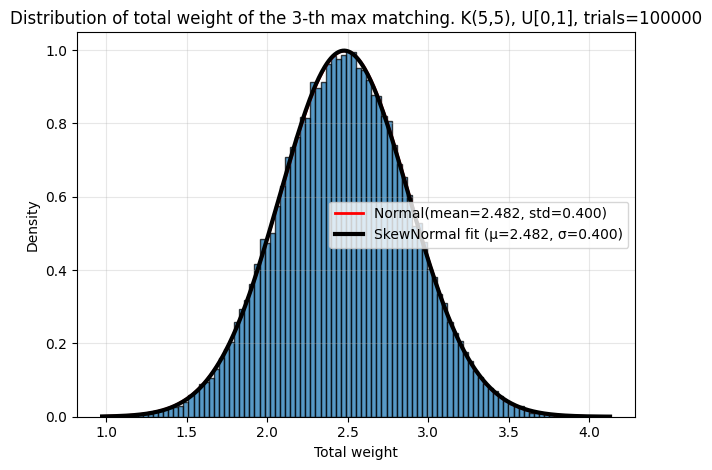

In [32]:
plot_kth_distribution(5, 3, trials=100000, bins=100)

Using SciPy linear_sum_assignment for Hungarian solver


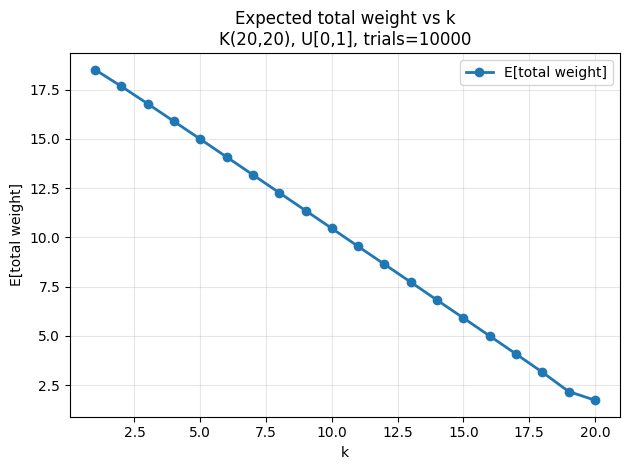

In [14]:
plot_expected_vs_k(20, trials=10000)

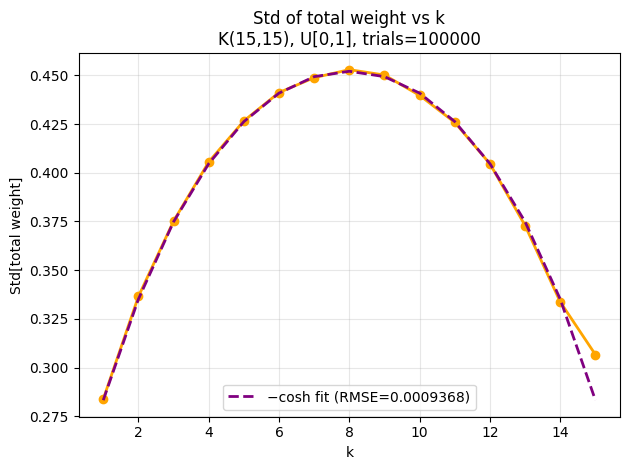

In [20]:
plot_std_vs_k(15, trials=100000)

k=1, n=3, trials=1000000: mean=2.062961, std=0.351274
k=2, n=3, trials=1000000: mean=1.473521, std=0.370046
k=3, n=3, trials=1000000: mean=0.963292, std=0.357412


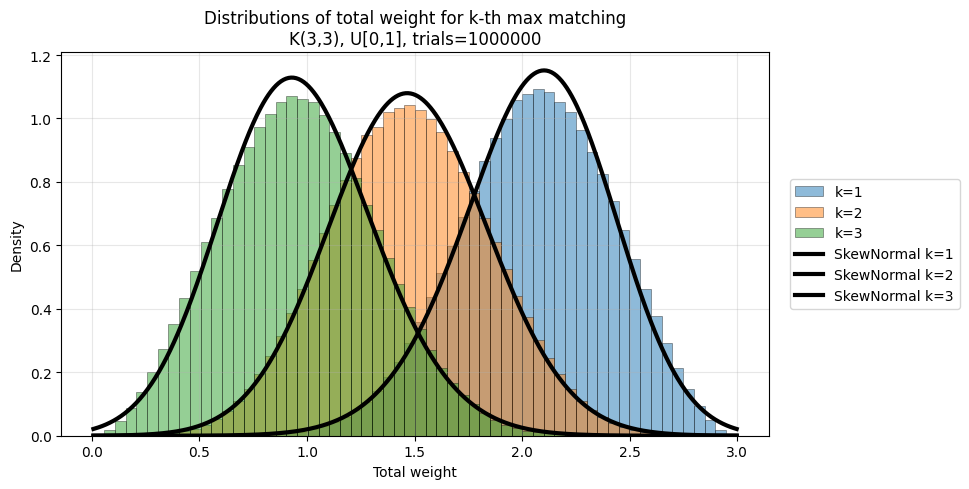

In [21]:
plot_k_range_distributions(3, 1, 3, trials=1000000, bins=60, alpha=0.5, show_normal=False, show_skew=True)

k=5, n=5, trials=100000: mean=1.219186, std=0.367751


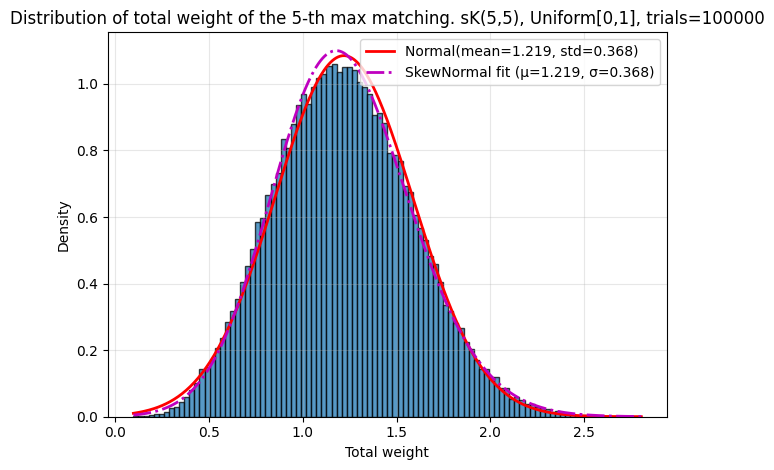

In [ ]:
plot_kth_distribution(5, 5, trials=100000, bins=100)

k=1, n=2, trials=1000000: mean=2.750959, std=1.478339
k=2, n=2, trials=1000000: mean=1.250393, std=0.829113


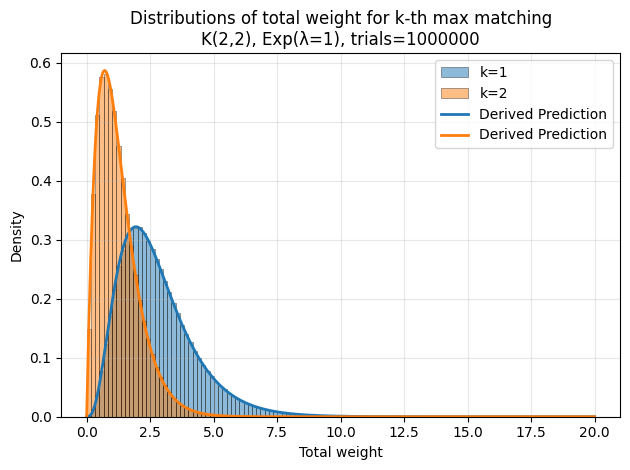

In [ ]:
plot_k_range_distributions(2, 1, 2, trials=1000000, bins=100, alpha=0.5, dist="exponential", rate=1, show_normal=False, show_skew=False)

k=1, n=2, trials=1000000: mean=1.233515, std=0.335239
k=2, n=2, trials=1000000: mean=0.766755, std=0.335112


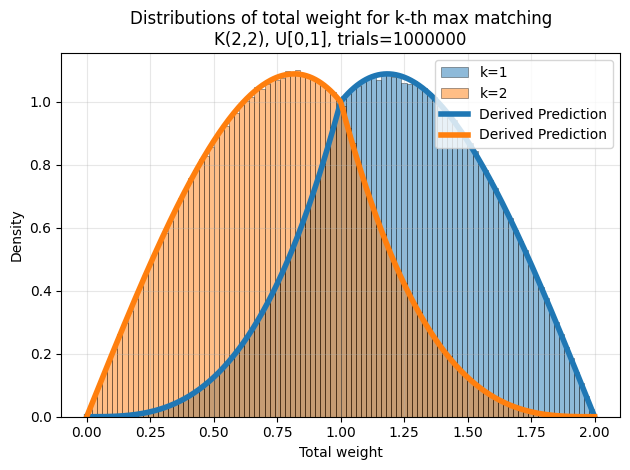

In [ ]:
plot_k_range_distributions(2, 1, 2, trials=1000000, bins=100, alpha=0.5, show_normal=False, show_skew=False)


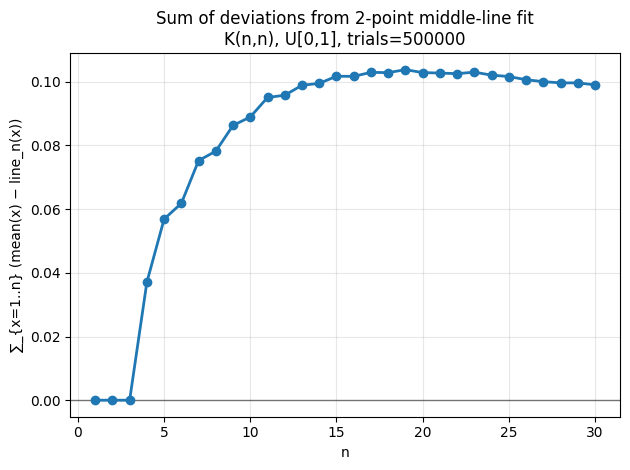

In [26]:
plot_final_matching_distributions_for_ns(30, trials=500000)


In [ ]:
print(deviation_of_max_matching_at_n(30, 500000))

KeyboardInterrupt: 

Using SciPy linear_sum_assignment for Hungarian solver
-0.8724873089604905
-0.9092304751528388
-0.9230755909627959
-0.9307107308927591
-0.932834106366542
-0.935786143860625
-0.9356025555149188
-0.9359091473004995
-0.9360747437822816
-0.9359722715472962
-0.9358298342160154
-0.9365909445271683
-0.9381132665308556
-0.9363946530575458
-0.9361813294039791
-0.9358625421659763
-0.9377167622999778
-0.9361204558067371
-0.9369746840611377
-0.9364628212166703
-0.9370001432594393
-0.9363677371367904
-0.9386627659654234
-0.9378412028072329
-0.9403564282185446
-0.9444342567705126
-0.9532124878247403
-1.033469653016549
-0.3843501826441318


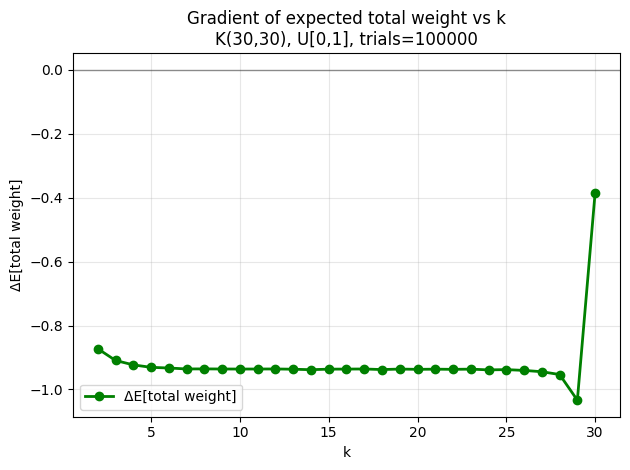

In [19]:
# Example: gradient of E[total weight] vs k
plot_gradient_expected_vs_k(30, trials=100000)